# ML Zoomcamp – Module 8 Homework (Hair Type CNN with PyTorch)

This notebook solves the **Hair Type** classification homework using **PyTorch**, following the official instructions:

- Build a small CNN from scratch (Conv → Pool → Dense → Dense).
- Train for 10 epochs without augmentation.
- Add data augmentation and train for 10 more epochs (continuing the same model).
- Compute the statistics needed for Questions 1–6:
  - Loss function choice
  - Total number of parameters
  - Median training accuracy (first 10 epochs)
  - Std dev of training loss (first 10 epochs)
  - Mean test loss over 10 augmented epochs
  - Average test accuracy for last 5 augmented epochs

** Note: This run of the data and model used Pytorch on Apple Silicon. Specifically a M4 MacMini


In [1]:
# 1) Imports and setup

import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set seeds so we can reproduce the results
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Chooses the device: MPS (Apple Silicon GPU) → CUDA (NVIDIA) → CPU.
if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device


device(type='mps')

In [2]:
# 2) Data paths and transforms (no augmentation)

data_root = "data"  # folder where you unzipped data.zip
train_dir = os.path.join(data_root, "train")
test_dir  = os.path.join(data_root, "test")

# Same transforms for train and test for the first 10 epochs
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

test_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir,  transform=test_transforms)

batch_size = 20

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# Sanity check for dataset length and classes
len(train_dataset), len(test_dataset), train_dataset.class_to_idx


(800, 201, {'curly': 0, 'straight': 1})

In [3]:
# 3) Model: CNN

class HairCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=0
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        # Compute flattened size:
        # Input: 200x200
        # After Conv(3x3, stride=1, pad=0): 200 -> 198
        # After MaxPool(2x2): 198 -> 99
        flattened_dim = 32 * 99 * 99  # channels * height * width

        self.fc1 = nn.Linear(flattened_dim, 64)
        self.fc2 = nn.Linear(64, 1)  # 1 logit for binary classification

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  # raw logits
        return x

model = HairCNN().to(device)
model


HairCNN(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=313632, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [4]:
# Calculate the total parameters

# Option 2: Manual counting
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")


Total parameters: 20073473


In [5]:
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.002,
    momentum=0.8
)


In [6]:
# Training loop (first 10 epochs, no augmentation)

num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)             # logits
        loss = criterion(outputs, labels)  # BCEWithLogitsLoss
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # For accuracy, convert logits -> probs via sigmoid, then threshold at 0.5
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        total_train += labels.size(0)
        correct_train += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    # ---- Validation / test ----
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            total_val += labels.size(0)
            correct_val += (preds == labels).sum().item()

    val_epoch_loss = val_running_loss / len(test_dataset)
    val_epoch_acc = correct_val / total_val

    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
        f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}"
    )


Epoch 1/10 | Loss: 0.6492, Acc: 0.6350 | Val Loss: 0.6069, Val Acc: 0.6617
Epoch 2/10 | Loss: 0.5565, Acc: 0.7050 | Val Loss: 0.7567, Val Acc: 0.6119
Epoch 3/10 | Loss: 0.5461, Acc: 0.7200 | Val Loss: 0.6025, Val Acc: 0.6418
Epoch 4/10 | Loss: 0.4670, Acc: 0.7675 | Val Loss: 0.7041, Val Acc: 0.5920
Epoch 5/10 | Loss: 0.4307, Acc: 0.7937 | Val Loss: 0.6119, Val Acc: 0.6766
Epoch 6/10 | Loss: 0.3459, Acc: 0.8438 | Val Loss: 0.7780, Val Acc: 0.6667
Epoch 7/10 | Loss: 0.2653, Acc: 0.8950 | Val Loss: 0.9606, Val Acc: 0.6368
Epoch 8/10 | Loss: 0.2238, Acc: 0.9175 | Val Loss: 0.7253, Val Acc: 0.7015
Epoch 9/10 | Loss: 0.1497, Acc: 0.9413 | Val Loss: 0.7697, Val Acc: 0.6816
Epoch 10/10 | Loss: 0.1669, Acc: 0.9337 | Val Loss: 0.7990, Val Acc: 0.7164


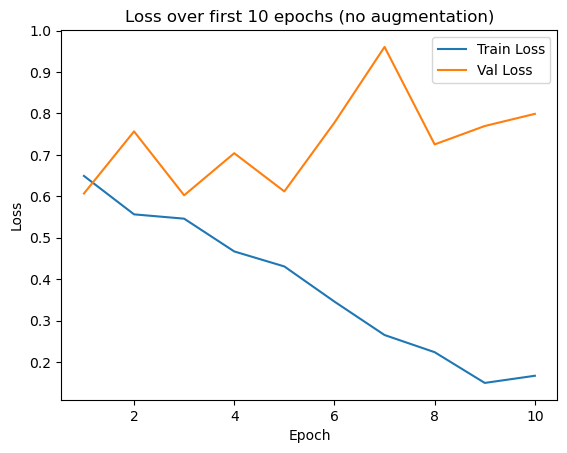

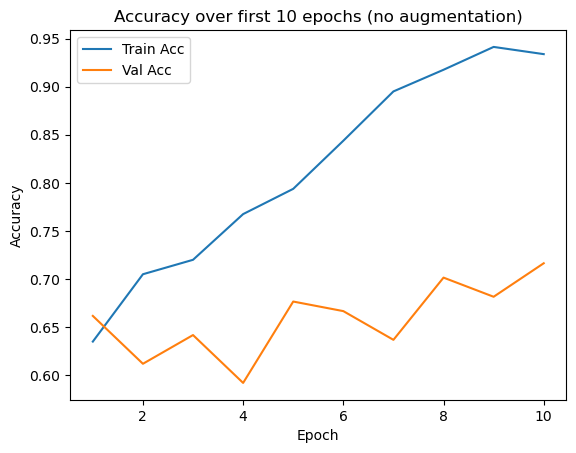

In [14]:
# Plot for first 10 epochs
# Losses

epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history['loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over first 10 epochs (no augmentation)')
plt.legend()
plt.show()

# Accuracy

plt.figure()
plt.plot(epochs, history['acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over first 10 epochs (no augmentation)')
plt.legend()
plt.show()

In [15]:
# Model stats

train_accs = np.array(history['acc'])
train_losses = np.array(history['loss'])

median_train_acc = np.median(train_accs)
std_train_loss   = np.std(train_losses)

print("Train accuracies by epoch:", train_accs)
print("Train losses by epoch: ", train_losses)
print("Median training accuracy:", median_train_acc)
print("Std of training loss:", std_train_loss)


Train accuracies by epoch: [0.635   0.705   0.72    0.7675  0.79375 0.84375 0.895   0.9175  0.94125
 0.93375]
Train losses by epoch:  [0.64924011 0.55648113 0.54606774 0.46697962 0.43074754 0.34589322
 0.26526612 0.22383897 0.14965101 0.16692494]
Median training accuracy: 0.81875
Std of training loss: 0.16689218452924134


In [9]:
# Augmentation added to the training data only

aug_train_transforms = transforms.Compose([
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(
        200,
        scale=(0.9, 1.0),
        ratio=(0.9, 1.1)
    ),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

aug_train_dataset = datasets.ImageFolder(train_dir, transform=aug_train_transforms)
aug_train_loader  = DataLoader(aug_train_dataset, batch_size=batch_size, shuffle=True)


In [10]:
# Train 10 more epochs but with augmentation this time on the same model

num_aug_epochs = 10
aug_history = {'val_loss': [], 'val_acc': []}

for epoch in range(num_aug_epochs):
    # ---- Train with augmented data ----
    model.train()
    for images, labels in aug_train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # ---- Evaluate on (non-augmented) test set ----
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            total_val += labels.size(0)
            correct_val += (preds == labels).sum().item()

    val_epoch_loss = val_running_loss / len(test_dataset)
    val_epoch_acc = correct_val / total_val

    aug_history['val_loss'].append(val_epoch_loss)
    aug_history['val_acc'].append(val_epoch_acc)

    print(
        f"[Aug] Epoch {epoch+1}/{num_aug_epochs} | "
        f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}"
    )


[Aug] Epoch 1/10 | Val Loss: 0.6065, Val Acc: 0.6965
[Aug] Epoch 2/10 | Val Loss: 0.6947, Val Acc: 0.6766
[Aug] Epoch 3/10 | Val Loss: 0.6693, Val Acc: 0.7114
[Aug] Epoch 4/10 | Val Loss: 0.5785, Val Acc: 0.6716
[Aug] Epoch 5/10 | Val Loss: 0.6299, Val Acc: 0.6667
[Aug] Epoch 6/10 | Val Loss: 0.6062, Val Acc: 0.7015
[Aug] Epoch 7/10 | Val Loss: 0.7190, Val Acc: 0.6418
[Aug] Epoch 8/10 | Val Loss: 0.8935, Val Acc: 0.6567
[Aug] Epoch 9/10 | Val Loss: 0.5866, Val Acc: 0.6915
[Aug] Epoch 10/10 | Val Loss: 0.5768, Val Acc: 0.7214


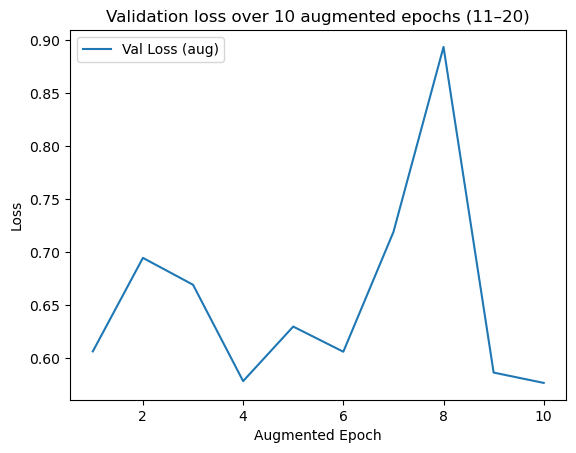

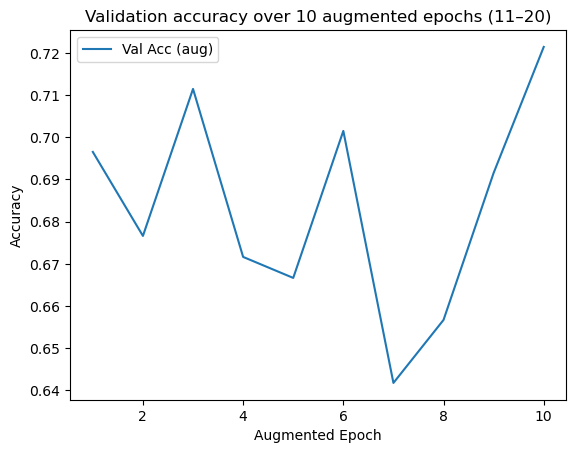

In [16]:
# Plots for Augmented epochs

aug_epochs = range(1, num_aug_epochs + 1)

# Losses
plt.figure()
plt.plot(aug_epochs, aug_history['val_loss'], label='Val Loss (aug)')
plt.xlabel('Augmented Epoch')
plt.ylabel('Loss')
plt.title('Validation loss over 10 augmented epochs (11–20)')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(aug_epochs, aug_history['val_acc'], label='Val Acc (aug)')
plt.xlabel('Augmented Epoch')
plt.ylabel('Accuracy')
plt.title('Validation accuracy over 10 augmented epochs (11–20)')
plt.legend()
plt.show()


In [12]:
# Model stats for augmented epochs

val_losses_aug = np.array(aug_history['val_loss'])
val_accs_aug   = np.array(aug_history['val_acc'])

mean_test_loss_over_aug_epochs = val_losses_aug.mean()
avg_test_acc_last5 = val_accs_aug[-5:].mean()

print("Val losses (aug epochs):", val_losses_aug)
print("Mean test loss over 10 aug epochs:", mean_test_loss_over_aug_epochs)
print("Val accuracies (aug epochs):", val_accs_aug)
print("Average test accuracy over last 5 aug epochs:", avg_test_acc_last5)


Val losses (aug epochs): [0.60653813 0.69466315 0.66933569 0.57851723 0.62992135 0.60620998
 0.71901927 0.893471   0.58657555 0.57681521]
Mean test loss over 10 aug epochs: 0.6561066572345905
Val accuracies (aug epochs): [0.69651741 0.67661692 0.71144279 0.67164179 0.66666667 0.70149254
 0.64179104 0.65671642 0.69154229 0.72139303]
Average test accuracy over last 5 aug epochs: 0.6825870646766169
